In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from dowhy import gcm

In [16]:
# Set random seed
np.random.seed(10)

# Set colours for plots
COLORS = [
    '#00B0F0',
    '#FF0000',
    '#B0F000'
]

# Plot causal graph given adjacency matrix
def plot_graph(input_graph):
    
    graph = nx.DiGraph(input_graph)

    plt.figure(figsize=(7, 7))
    nx.draw(
    G=graph,
    node_color=COLORS[0],
    node_size=7000,
    arrowsize=17,
    with_labels=True,
    labels=node_lookup,
    font_color='white',
    font_size=9,
    pos=nx.circular_layout(graph)
    )

# function to convert absolute values to percentage from dictionary
def convert_to_percentage(value_dictionary):
    total_absolute_sum = np.sum([abs(v) for v in value_dictionary.values()])
    return {k: round(abs(v) / total_absolute_sum * 100, 1) for k, v in value_dictionary.items()}

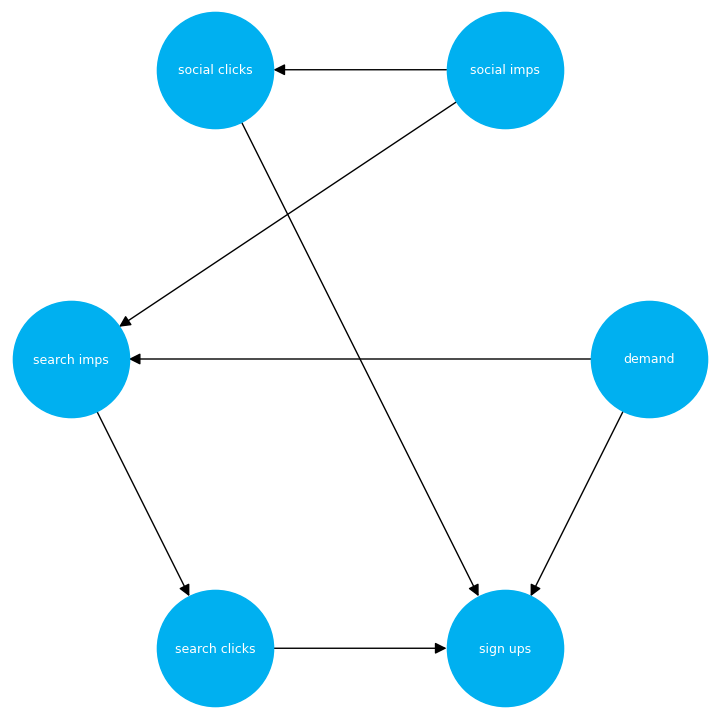

In [17]:
# Create node lookup for channels
node_lookup = {0: 'demand',
    1: 'social imps',                
    2: 'social clicks',
    3: 'search imps',
    4: 'search clicks',
    5: 'sign ups'                                                                             
 }

total_nodes = len(node_lookup)

# Create adjacency matrix - this is the basis for our known graph
graph_actual = np.zeros((total_nodes, total_nodes))

# Create known graph using expert domain knowledge
graph_actual[0, 3] = 1.0 # demand -> search imps
graph_actual[0, 5] = 1.0 # demand -> sign ups

graph_actual[1, 2] = 1.0 # social imps -> social clicks
graph_actual[1, 3] = 1.0 # social imps -> search imps

graph_actual[2, 5] = 1.0 # social clicks -> signups

graph_actual[3, 4] = 1.0 # search imps -> search clicks

graph_actual[4, 5] = 1.0 # search clicks -> signups

plot_graph(graph_actual)

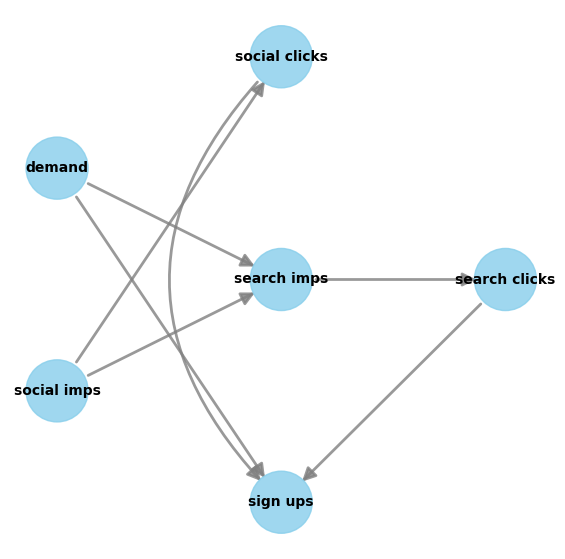

In [19]:
# Setup graph
graph = nx.from_numpy_array(graph_actual, create_using=nx.DiGraph)
graph = nx.relabel_nodes(graph, node_lookup)
gcm.util.plot(graph, figure_size=(7, 7))

In [21]:
# Create data behind graph
df = pd.DataFrame(columns=node_lookup.values())
df['demand'] = np.random.normal(loc=0, scale=1, size=1000)
df['social imps'] = (0.10 * df['demand']) + np.random.normal(loc=0, scale=1, size=1000)
df['social clicks'] = (0.10 * df['social imps']) + np.random.normal(loc=0, scale=1, size=1000)
df['search imps'] = (0.30 * df['demand']) + (0.05 * df['social imps'])  + np.random.normal(loc=0, scale=1, size=1000)
df['search clicks'] = (0.25 * df['search imps']) + np.random.normal(loc=0, scale=1, size=1000)
df['sign ups'] = (0.50 * df['demand']) + (0.10 * df['social clicks']) + (0.30 * df['search clicks']) + np.random.normal(loc=0, scale=1, size=1000)
df

,demand,social imps,social clicks,search imps,search clicks,sign ups
0,0.560975,1.343406,1.091775,0.065883,1.099406,0.653930
1,0.987484,-0.647254,0.276694,1.409863,-0.390970,-0.335964
2,-0.787914,-0.706473,-0.432836,0.755421,-0.755419,-0.589305
3,-1.387340,0.554630,-1.135857,-0.296258,-0.428919,-0.433448
4,-0.994742,0.884842,-1.456439,0.689514,0.750837,1.023223
...,...,...,...,...,...,...
995,0.029330,0.598713,-0.634410,-0.293696,-0.599291,-0.237972
996,1.329238,1.308160,-0.086082,0.540154,1.289845,1.094906
997,-0.078216,2.708518,3.026619,-0.571568,0.190385,0.194538
998,-1.245869,-0.234383,0.128535,-1.110353,0.730769,-0.173701


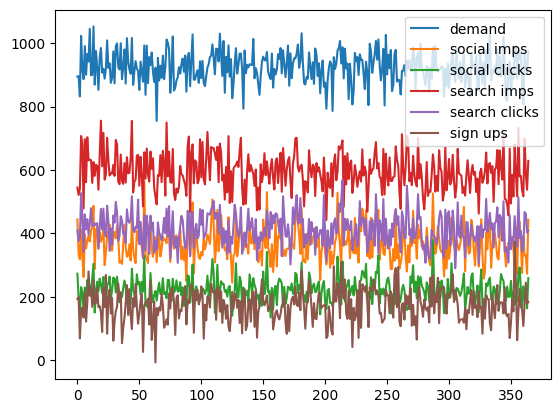

In [111]:
# Make numbers more realistic
population = 1000
df = pd.DataFrame(columns=node_lookup.values())
df['demand'] = (population * np.random.uniform(0.90, 0.95, 365)) + np.random.normal(loc=0, scale=population*0.05, size=365)
df['social imps'] = (0.40 * df['demand']) + np.random.normal(loc=0, scale=df['demand']*0.05, size=365)
df['social clicks'] = (0.60 * df['social imps']) + np.random.normal(loc=0, scale=df['social imps']*0.05, size=365)
df['search imps'] = (0.60 * df['demand']) + (0.10 * df['social imps'])  + np.random.normal(loc=0, scale=df['demand']*0.05, size=365)
df['search clicks'] = (0.70 * df['search imps']) + np.random.normal(loc=0, scale=df['search imps']*0.05, size=365)
df['sign ups'] = (0.10 * df['demand']) + (0.10 * df['social clicks']) + (0.15 * df['search clicks']) + np.random.normal(loc=0, scale=df['demand']*0.05, size=365)
timeseries_plot = df.plot.line()

In [112]:
# Create SCM
causal_model = gcm.InvertibleStructuralCausalModel(graph)

causal_model.set_causal_mechanism('demand', gcm.EmpiricalDistribution())
causal_model.set_causal_mechanism('social imps', gcm.EmpiricalDistribution())

causal_model.set_causal_mechanism('social clicks', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('search imps', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('search clicks', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('sign ups', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))

gcm.fit(causal_model, df)

Fitting causal mechanism of node sign ups: 100%|██████████| 6/6 [00:00<00:00, 124.21it/s]


In [ ]:
# Check model fit statistics

In [ ]:
# Calculate counterfactuals

In [ ]:
# Calcuate intervetions

In [116]:
# Arrow strengths
strength = gcm.arrow_strength(causal_model, target_node='sign ups')
convert_to_percentage(strength)

{('demand', 'sign ups'): 73.6,
 ('search clicks', 'sign ups'): 15.7,
 ('social clicks', 'sign ups'): 10.7}

In [117]:
# Attributions
shapley = gcm.intrinsic_causal_influence(causal_model, target_node='sign ups')
convert_to_percentage(shapley)

Estimating Shapley Values. Average change of Shapley values in run 11 (55 evaluated permutations): 1.1035060571709423%: 100%|██████████| 1/1 [00:03<00:00,  3.74s/it]


{'demand': 5.7,
 'social imps': 0.4,
 'social clicks': 0.2,
 'search imps': 0.1,
 'search clicks': 0.6,
 'sign ups': 93.0}

In [ ]:
# TODO: simplyfy mmm graph to be imps and demand

In [86]:
# Set graph for MMM

# Create adjacency matrix - this is the basis for our known graph
graph_actual_mmm = np.zeros((total_nodes, total_nodes))

# Create known graph using expert domain knowledge
graph_actual_mmm[0, 8] = 1.0 # demand -> signups
graph_actual_mmm[1, 8] = 1.0 # tv spend -> signups
graph_actual_mmm[2, 8] = 1.0 # social spend -> signups
graph_actual_mmm[3, 8] = 1.0 # social clicks -> signups
graph_actual_mmm[4, 8] = 1.0 # paid search imps -> signups
graph_actual_mmm[5, 8] = 1.0 # paid search clicks -> signups
graph_actual_mmm[6, 8] = 1.0 # organic search imps -> signups
graph_actual_mmm[7, 8] = 1.0 # organic search clicks -> signups

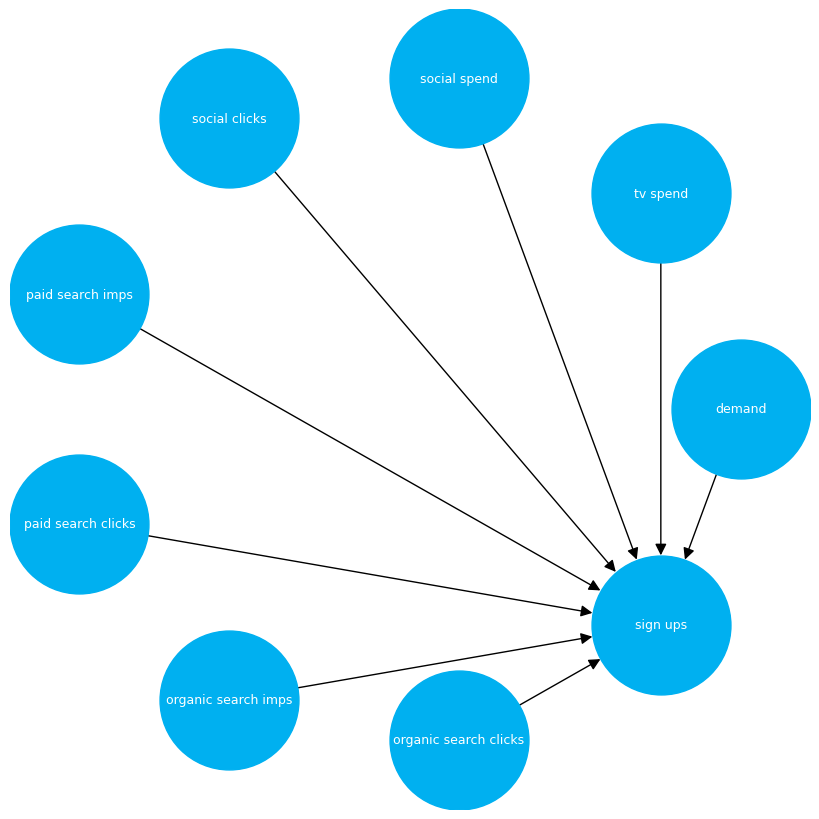

In [87]:
plot_graph(graph_actual_mmm)

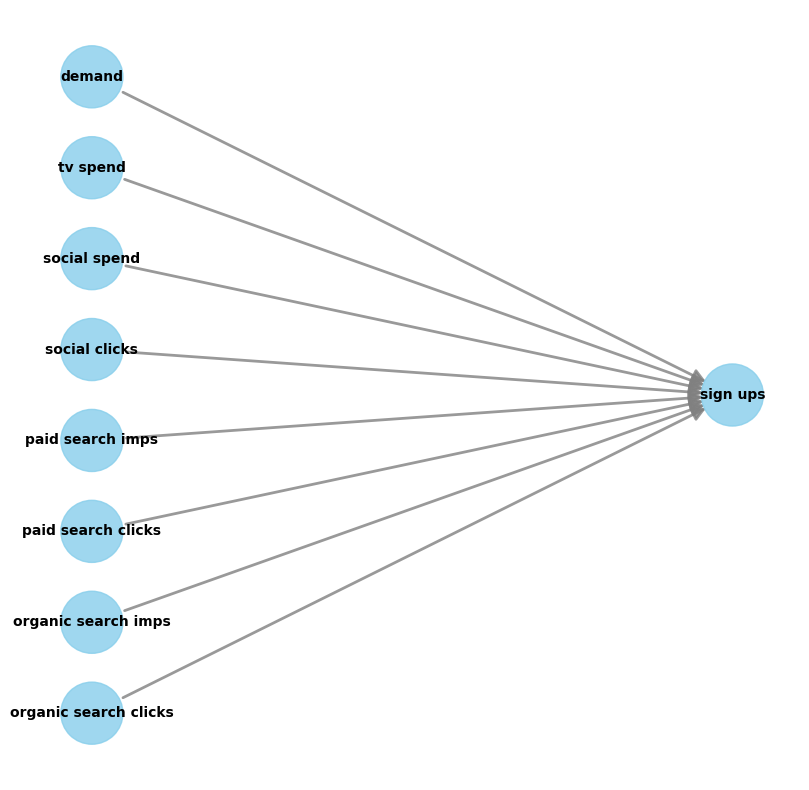

In [90]:
# Setup graph
graph_mmm = nx.from_numpy_array(graph_actual_mmm, create_using=nx.DiGraph)
graph_mmm = nx.relabel_nodes(graph_mmm, node_lookup)
gcm.util.plot(graph_mmm, figure_size=(10, 10))

In [91]:
# Create SCM
causal_model_mmm = gcm.InvertibleStructuralCausalModel(graph_mmm)

causal_model_mmm.set_causal_mechanism('demand', gcm.EmpiricalDistribution())
causal_model_mmm.set_causal_mechanism('tv spend', gcm.EmpiricalDistribution())
causal_model_mmm.set_causal_mechanism('social spend', gcm.EmpiricalDistribution())
causal_model_mmm.set_causal_mechanism('social clicks', gcm.EmpiricalDistribution())
causal_model_mmm.set_causal_mechanism('paid search imps', gcm.EmpiricalDistribution())
causal_model_mmm.set_causal_mechanism('paid search clicks', gcm.EmpiricalDistribution())
causal_model_mmm.set_causal_mechanism('organic search imps', gcm.EmpiricalDistribution())
causal_model_mmm.set_causal_mechanism('organic search clicks', gcm.EmpiricalDistribution())

causal_model_mmm.set_causal_mechanism('sign ups', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))

gcm.fit(causal_model_mmm, df)

Fitting causal mechanism of node sign ups: 100%|██████████| 9/9 [00:00<00:00, 1078.66it/s]   


In [93]:
# Arrow strengths
gcm.arrow_strength(causal_model_mmm, target_node='sign ups')

{('demand', 'sign ups'): 0.462217060565486,
 ('organic search clicks', 'sign ups'): 1.1525111727054247,
 ('organic search imps', 'sign ups'): 0.010219744451554118,
 ('paid search clicks', 'sign ups'): 2.7850186168663202,
 ('paid search imps', 'sign ups'): 0.23009577492668426,
 ('social clicks', 'sign ups'): 0.03625088137543338,
 ('social spend', 'sign ups'): 0.12657798805403286,
 ('tv spend', 'sign ups'): 0.13818247931536068}

In [94]:
# Attributions
shapley_mmm = gcm.intrinsic_causal_influence(causal_model_mmm, target_node='sign ups')


def convert_to_percentage(value_dictionary):
    total_absolute_sum = np.sum([abs(v) for v in value_dictionary.values()])
    return {k: round(abs(v) / total_absolute_sum * 100, 1) for k, v in value_dictionary.items()}

convert_to_percentage(shapley_mmm)

Estimating Shapley Values. Average change of Shapley values in run 11 (55 evaluated permutations): 0.4761908630969468%: 100%|██████████| 1/1 [00:16<00:00, 16.28s/it]


{'demand': 8.2,
 'tv spend': 2.2,
 'social spend': 2.9,
 'social clicks': 0.6,
 'paid search imps': 4.6,
 'paid search clicks': 45.4,
 'organic search imps': 0.0,
 'organic search clicks': 19.1,
 'sign ups': 16.9}